In [81]:
!pip install pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
    --------------------------------------- 10.2/614.7 kB ? eta -:--:--
   - ------------------------------------- 20.5/614.7 kB 217.9 kB/s eta 0:00:03
   -- ------------------------------------ 41.0/614.7 kB 393.8 kB/s eta 0:00:02
   ----- --------------------------------- 92.2/614.7 kB 585.1 kB/s eta 0:00:01
   --------------- ------------------------ 235.5/614.7 kB 1.3 MB/s eta 0:00:01
   ------------------------- -------------- 389.1/614.7 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------  614.4/614.7 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -------------- ------------------------- 1.0/2.8 MB 31.4 MB/s eta 0:00:01
   ----------------------------------- ---- 2.5/2.8 MB 39.5 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 29.5 MB/s eta 0:00:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

In [3]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data = data[['traffic_volume', 'date_time', 'holiday', 'temp']]
data.head()

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,NaN,288.28
1,4516,2012-10-02 10:00:00,NaN,289.36
2,4767,2012-10-02 11:00:00,NaN,289.58
3,5026,2012-10-02 12:00:00,NaN,290.13
4,4918,2012-10-02 13:00:00,NaN,291.14


In [5]:
data.describe()

,traffic_volume,temp
count,48204.000000,48204.000000
mean,3259.818355,281.205870
std,1986.860670,13.338232
min,0.000000,0.000000
25%,1193.000000,272.160000
50%,3380.000000,282.450000
75%,4933.000000,291.806000
max,7280.000000,310.070000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   traffic_volume  48204 non-null  int64  
 1   date_time       48204 non-null  object 
 2   holiday         61 non-null     object 
 3   temp            48204 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [7]:
data['holiday'].drop_duplicates()

0                              NaN
126                   Columbus Day
1123                  Veterans Day
1370              Thanksgiving Day
2360                 Christmas Day
2559                 New Years Day
3697          Washingtons Birthday
6430                  Memorial Day
7414              Independence Day
8575                    State Fair
8742                     Labor Day
11611    Martin Luther King Jr Day
Name: holiday, dtype: object

<Axes: xlabel='date_time'>

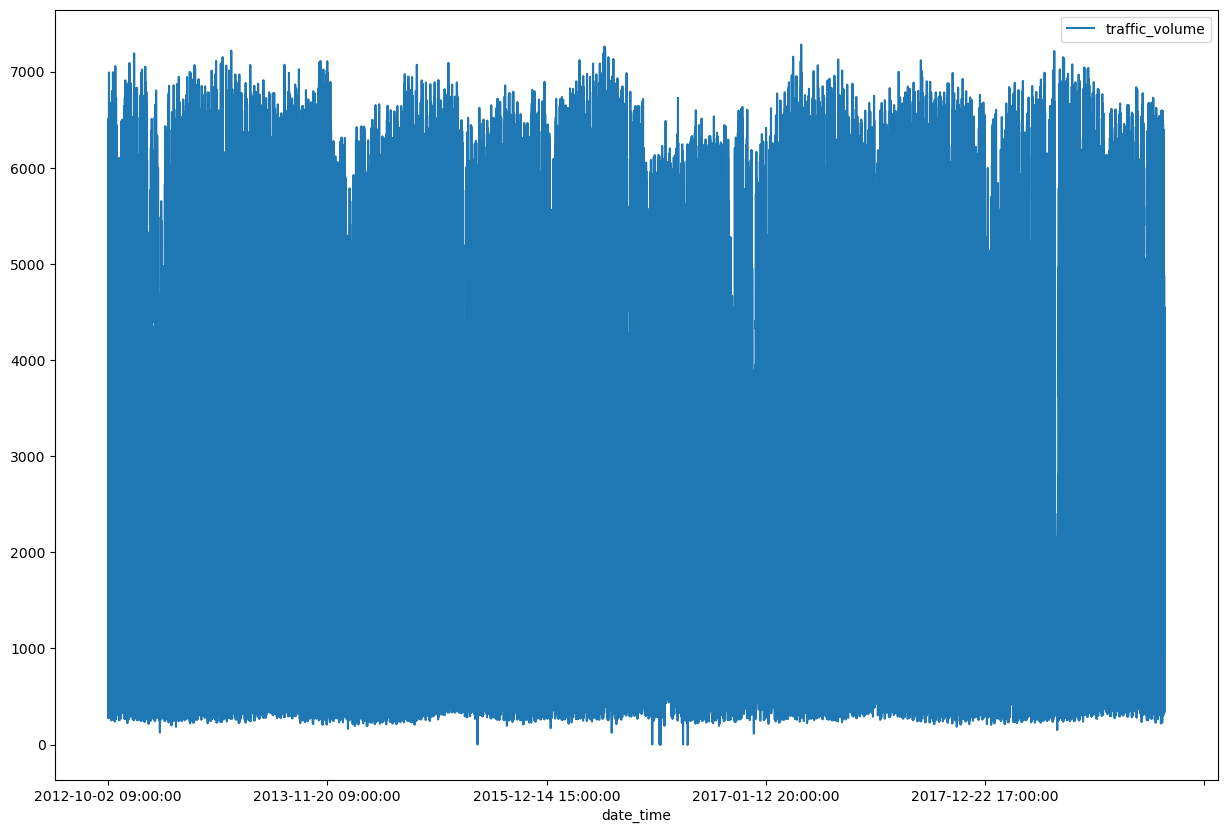

In [8]:
data.plot(x='date_time', y='traffic_volume', figsize=(15,10))

In [9]:
data['date_time'] = pd.to_datetime(data['date_time'],
               format='%Y-%m-%d %H:%M:%S')
test_time_slots = data['date_time'].diff().dt.total_seconds()/3600

In [10]:
test_time_slots.drop_duplicates()

0           NaN
1           1.0
22          2.0
24          3.0
179         0.0
206         4.0
235         5.0
486         8.0
488         9.0
2796        7.0
3186       13.0
3220       25.0
3971        6.0
8681       14.0
8741       47.0
8768       30.0
8818       15.0
8905       12.0
9069       11.0
9219       22.0
9221       24.0
9625       17.0
9636       10.0
9661      243.0
14012     117.0
15144      21.0
15797      65.0
15865      33.0
15971    7387.0
15978     118.0
15981      18.0
15982      34.0
19159      93.0
Name: date_time, dtype: float64

Вывод: временные интервалы между точками не всегда 1 час. Наличие интервалов длины 0 говорит о наличии дубликатов.

In [11]:
data = data.groupby('date_time').agg({'traffic_volume':'mean', 'holiday':'max', 'temp':'mean'}).reset_index()
data.head()

,date_time,traffic_volume,holiday,temp
0,2012-10-02 09:00:00,5545.0,NaN,288.28
1,2012-10-02 10:00:00,4516.0,NaN,289.36
2,2012-10-02 11:00:00,4767.0,NaN,289.58
3,2012-10-02 12:00:00,5026.0,NaN,290.13
4,2012-10-02 13:00:00,4918.0,NaN,291.14


In [12]:
min_datetime = data.date_time.min()
max_datetime = data.date_time.max()
min_datetime, max_datetime

(Timestamp('2012-10-02 09:00:00'), Timestamp('2018-09-30 23:00:00'))

In [13]:
dt = pd.date_range(min_datetime, max_datetime, freq='1h').to_frame()
dt.columns = ['date_time']
dt.head()

,date_time
2012-10-02 09:00:00,2012-10-02 09:00:00
2012-10-02 10:00:00,2012-10-02 10:00:00
2012-10-02 11:00:00,2012-10-02 11:00:00
2012-10-02 12:00:00,2012-10-02 12:00:00
2012-10-02 13:00:00,2012-10-02 13:00:00


In [14]:
data = dt.merge(data, on = 'date_time', how = 'left')

In [15]:
data.shape

(52551, 4)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52551 entries, 0 to 52550
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       52551 non-null  datetime64[ns]
 1   traffic_volume  40575 non-null  float64       
 2   holiday         53 non-null     object        
 3   temp            40575 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.6+ MB


In [17]:
data['traffic_volume'] = data['traffic_volume'].interpolate()
data['temp'] = data['temp'].interpolate()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52551 entries, 0 to 52550
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       52551 non-null  datetime64[ns]
 1   traffic_volume  52551 non-null  float64       
 2   holiday         53 non-null     object        
 3   temp            52551 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.6+ MB


In [18]:
data.loc[~data['holiday'].isnull(), 'holiday'] = 1
data['holiday'].fillna(0, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52551 entries, 0 to 52550
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       52551 non-null  datetime64[ns]
 1   traffic_volume  52551 non-null  float64       
 2   holiday         52551 non-null  int64         
 3   temp            52551 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.6 MB


<Axes: xlabel='date_time'>

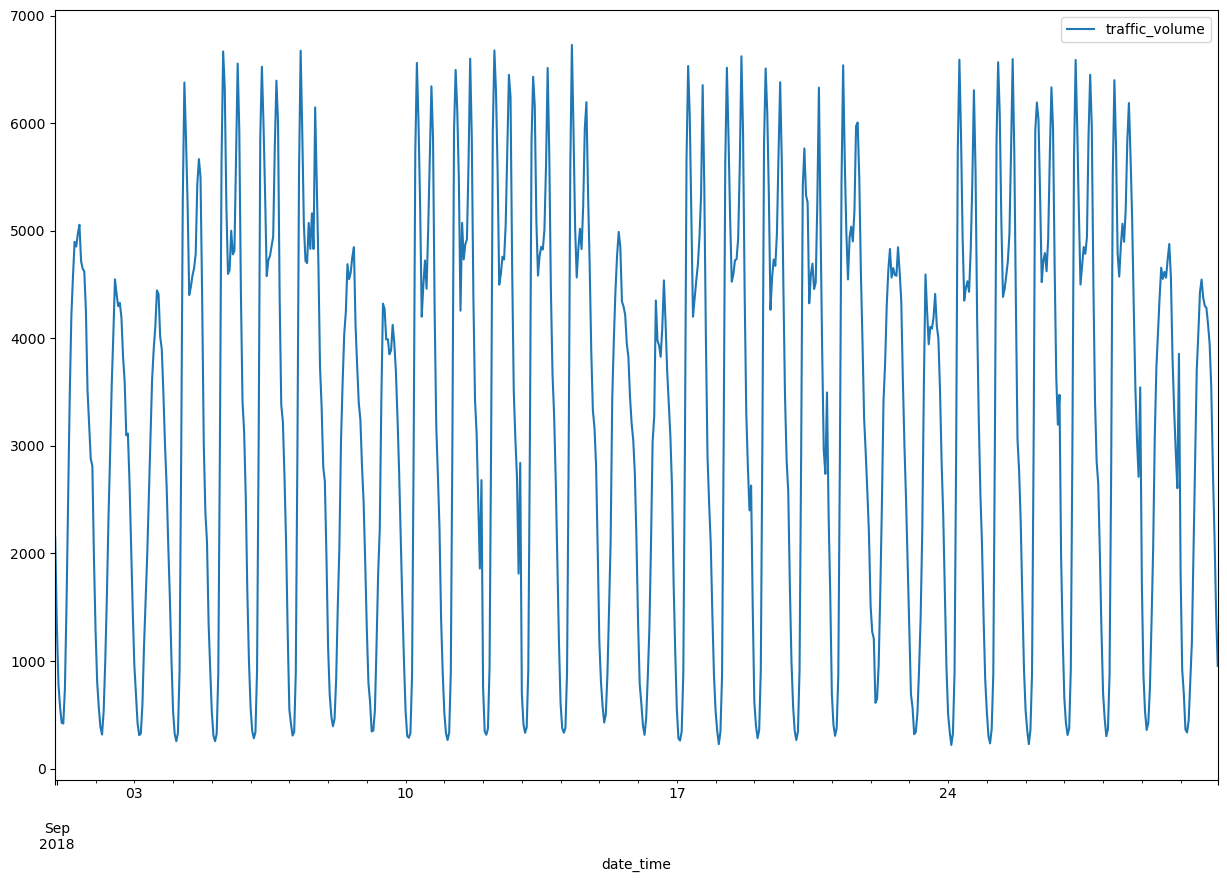

In [19]:
data_last_month = data[data['date_time']>=max_datetime - timedelta(days=30)]
data_last_month.plot(x='date_time', y='traffic_volume', figsize=(15,10))

видна характерная недельная сезонность и пики в часы пик. Тренда не видно.

<Axes: xlabel='date_time'>

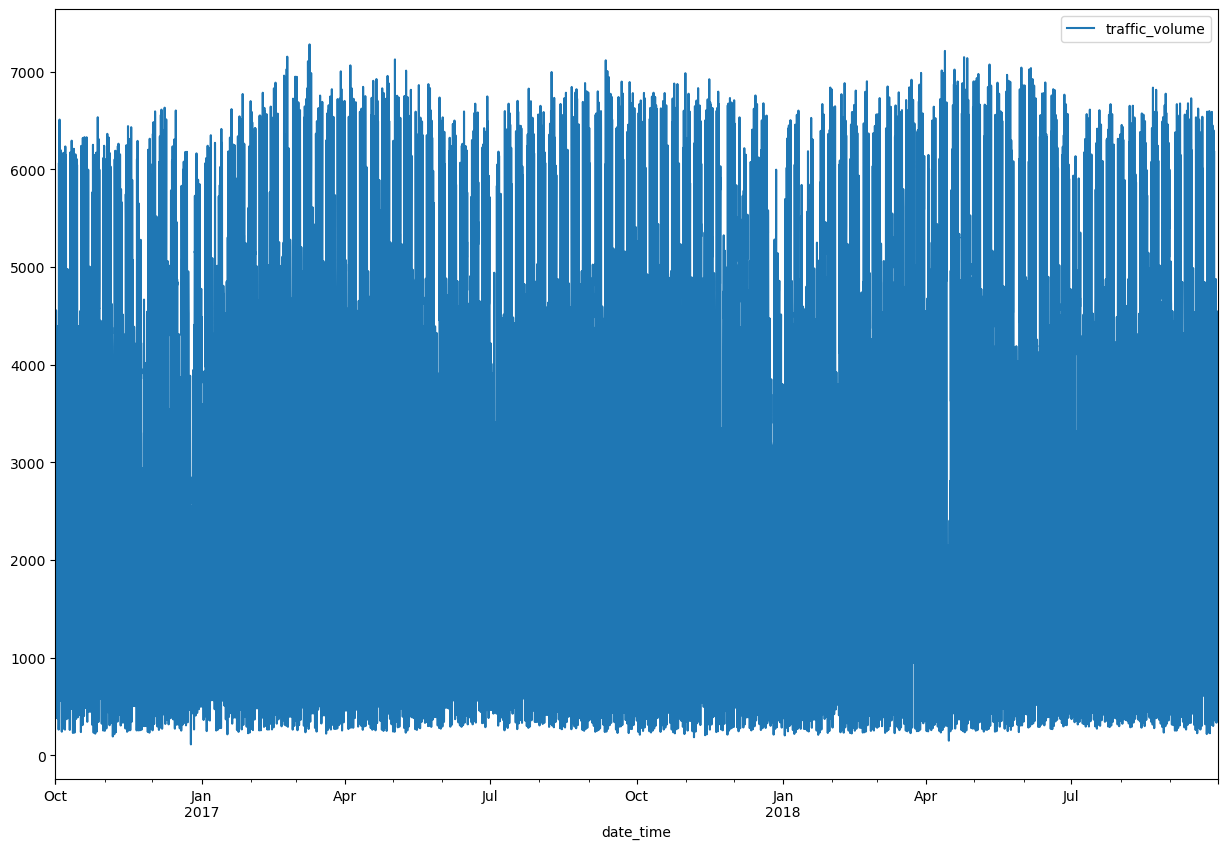

In [20]:
data_last_two_years = data[data['date_time']>=max_datetime - timedelta(days=730)]
data_last_two_years.plot(x='date_time', y='traffic_volume', figsize=(15,10))

видны провалы на рождество и Новый Год, а также снижение трафика в летний период. Для прогнозирования нам будет достаточно данных за 2 года.

In [21]:
data = data_last_two_years

In [22]:
data['month'] = data.date_time.dt.month
data['dayofweek'] = data.date_time.dt.dayofweek
data['hour'] = data.date_time.dt.hour
data['dayofyear'] = data.date_time.dt.dayofyear

In [23]:
data.head()

,date_time,traffic_volume,holiday,temp,month,dayofweek,hour,dayofyear
35030,2016-09-30 23:00:00,1727.0,0,286.61,9,4,23,274
35031,2016-10-01 00:00:00,1195.0,0,286.22,10,5,0,275
35032,2016-10-01 01:00:00,776.0,0,285.60,10,5,1,275
35033,2016-10-01 02:00:00,666.0,0,285.49,10,5,2,275
35034,2016-10-01 03:00:00,448.0,0,284.59,10,5,3,275


In [24]:
train_test_split_date = max_datetime - timedelta(days=7)
data_train = data[data['date_time']<train_test_split_date]
data_test = data[data['date_time']>=train_test_split_date]

# Baseline

In [25]:
baseline = data_train.groupby(["dayofweek", "hour"])["traffic_volume"].mean().reset_index()
baseline.columns = ['dayofweek',	'hour',	'traffic_volume_pred']
baseline.head()

,dayofweek,hour,traffic_volume_pred
0,0,0,646.961165
1,0,1,401.854369
2,0,2,305.165049
3,0,3,355.174757
4,0,4,823.922330


In [26]:
test = data_test.copy().merge(baseline, on = ['dayofweek',	'hour'])
test

,date_time,traffic_volume,holiday,temp,month,dayofweek,hour,dayofyear,traffic_volume_pred
0,2018-09-23 23:00:00,934.0,0,291.12,9,6,23,266,1236.174757
1,2018-09-30 23:00:00,954.0,0,282.12,9,6,23,273,1236.174757
2,2018-09-24 00:00:00,509.0,0,290.35,9,0,0,267,646.961165
3,2018-09-24 01:00:00,344.0,0,289.75,9,0,1,267,401.854369
4,2018-09-24 02:00:00,219.0,0,289.02,9,0,2,267,305.165049
...,...,...,...,...,...,...,...,...,...
164,2018-09-30 18:00:00,3947.0,0,284.20,9,6,18,273,3672.153846
165,2018-09-30 19:00:00,3543.0,0,283.45,9,6,19,273,3167.317308
166,2018-09-30 20:00:00,2781.0,0,282.76,9,6,20,273,2824.394231
167,2018-09-30 21:00:00,2159.0,0,282.73,9,6,21,273,2376.288462


In [27]:

print('mae={0}, mape={1}'.format(mae(test['traffic_volume'], test['traffic_volume_pred']),mape(test['traffic_volume'], test['traffic_volume_pred'])))

mae=188.0833655637463, mape=0.07887809802498953


<Axes: xlabel='date_time'>

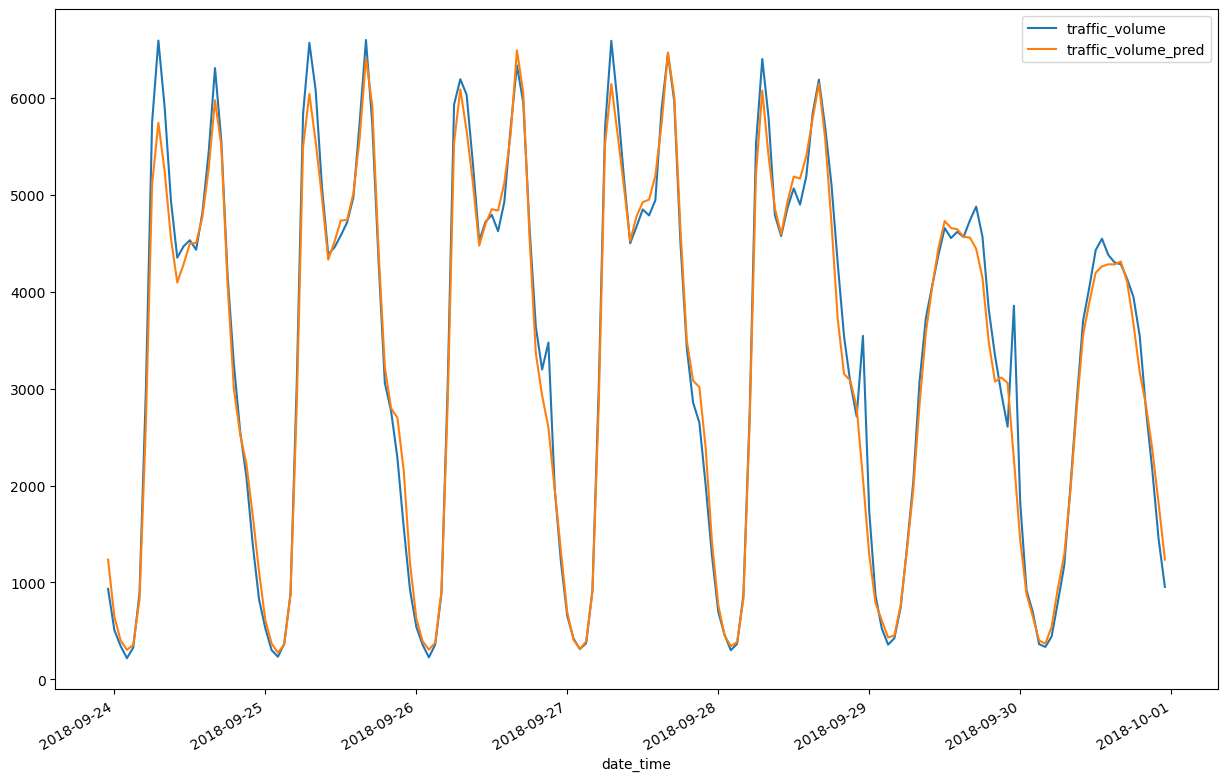

In [28]:
fig, ax = plt.subplots(1, 1)

test.plot(x='date_time', y='traffic_volume', ax = ax, figsize=(15,10))
test.plot(x='date_time', y='traffic_volume_pred', ax = ax, figsize=(15,10))

In [29]:
X_train = data_train.drop(['date_time', 'traffic_volume'], axis=1)
y_train = data_train['traffic_volume']
X_test = data_test.drop(['date_time', 'traffic_volume'], axis=1)
y_test = data_test['traffic_volume']

# auto_arima

In [107]:
import pmdarima as pm
model = pm.auto_arima(y_train,
                      X=X_train,
                      seasonal=True,
                      stepwise=True,
                      suppress_warnings=True,
                      max_order=None,
                      information_criterion='aicc',
                      error_action="ignore")

In [108]:
forecast = model.predict(n_periods=len(X_test), X=X_test)
forecast

C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


17352    1359.297583
17353    2123.665370
17354    2443.395182
17355    2806.708970
17356    3139.085635
            ...     
17516    2938.311428
17517    2930.278522
17518    2931.203083
17519    2923.848772
17520    2925.587648
Length: 169, dtype: float64

In [109]:
test = data_test.copy()
test['traffic_volume_pred'] = list(forecast)
test

C:\Users\Asus\AppData\Local\Temp\ipykernel_4248\35001515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['traffic_volume_pred'] = list(forecast)


,date_time,traffic_volume,holiday,temp,month,dayofweek,hour,dayofyear,traffic_volume_pred
52382,2018-09-23 23:00:00,934.0,0,291.12,9,6,23,266,1359.297583
52383,2018-09-24 00:00:00,509.0,0,290.35,9,0,0,267,2123.665370
52384,2018-09-24 01:00:00,344.0,0,289.75,9,0,1,267,2443.395182
52385,2018-09-24 02:00:00,219.0,0,289.02,9,0,2,267,2806.708970
52386,2018-09-24 03:00:00,328.0,0,288.78,9,0,3,267,3139.085635
...,...,...,...,...,...,...,...,...,...
52546,2018-09-30 19:00:00,3543.0,0,283.45,9,6,19,273,2938.311428
52547,2018-09-30 20:00:00,2781.0,0,282.76,9,6,20,273,2930.278522
52548,2018-09-30 21:00:00,2159.0,0,282.73,9,6,21,273,2931.203083
52549,2018-09-30 22:00:00,1450.0,0,282.09,9,6,22,273,2923.848772


In [110]:
print('mae={0}, mape={1}'.format(mae(test['traffic_volume'], test['traffic_volume_pred']),mape(test['traffic_volume'], test['traffic_volume_pred'])))

mae=1695.4187339276211, mape=1.6487063189407065


<Axes: xlabel='date_time'>

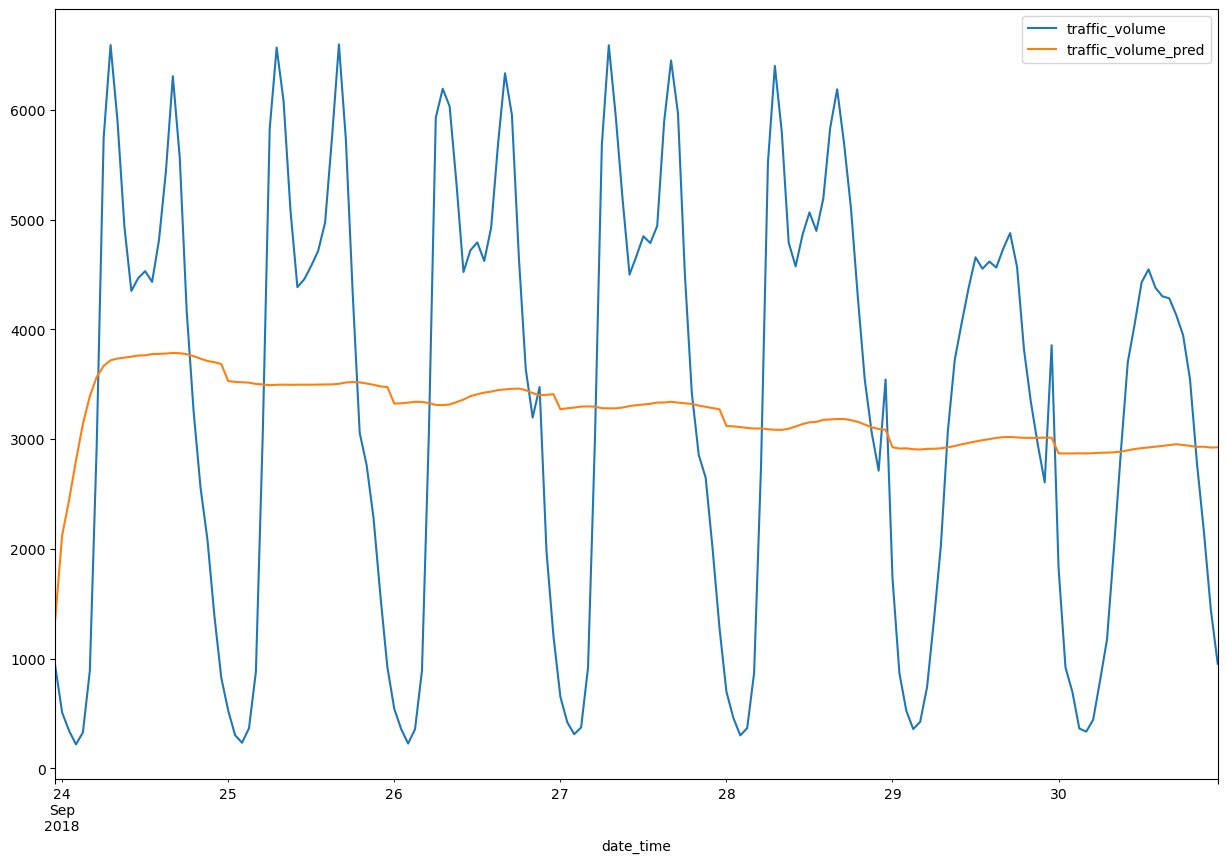

In [111]:
fig, ax = plt.subplots(1, 1)

test.plot(x='date_time', y='traffic_volume', ax = ax, figsize=(15,10))
test.plot(x='date_time', y='traffic_volume_pred', ax = ax, figsize=(15,10))


# Случайный лес на имеющихся фичах

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=0)

In [31]:
forecast = rf.predict(X_test)

In [32]:
test = data_test.copy()
test['traffic_volume_pred'] = list(forecast)
test

,date_time,traffic_volume,holiday,temp,month,dayofweek,hour,dayofyear,traffic_volume_pred
52382,2018-09-23 23:00:00,934.0,0,291.12,9,6,23,266,1720.872
52383,2018-09-24 00:00:00,509.0,0,290.35,9,0,0,267,628.388
52384,2018-09-24 01:00:00,344.0,0,289.75,9,0,1,267,381.661
52385,2018-09-24 02:00:00,219.0,0,289.02,9,0,2,267,266.902
52386,2018-09-24 03:00:00,328.0,0,288.78,9,0,3,267,345.313
...,...,...,...,...,...,...,...,...,...
52546,2018-09-30 19:00:00,3543.0,0,283.45,9,6,19,273,3469.281
52547,2018-09-30 20:00:00,2781.0,0,282.76,9,6,20,273,2615.126
52548,2018-09-30 21:00:00,2159.0,0,282.73,9,6,21,273,2115.900
52549,2018-09-30 22:00:00,1450.0,0,282.09,9,6,22,273,1641.131


In [33]:
print('mae={0}, mape={1}'.format(mae(test['traffic_volume'], test['traffic_volume_pred']),mape(test['traffic_volume'], test['traffic_volume_pred'])))

mae=182.17303571428573, mape=0.07553286530826607


<Axes: xlabel='date_time'>

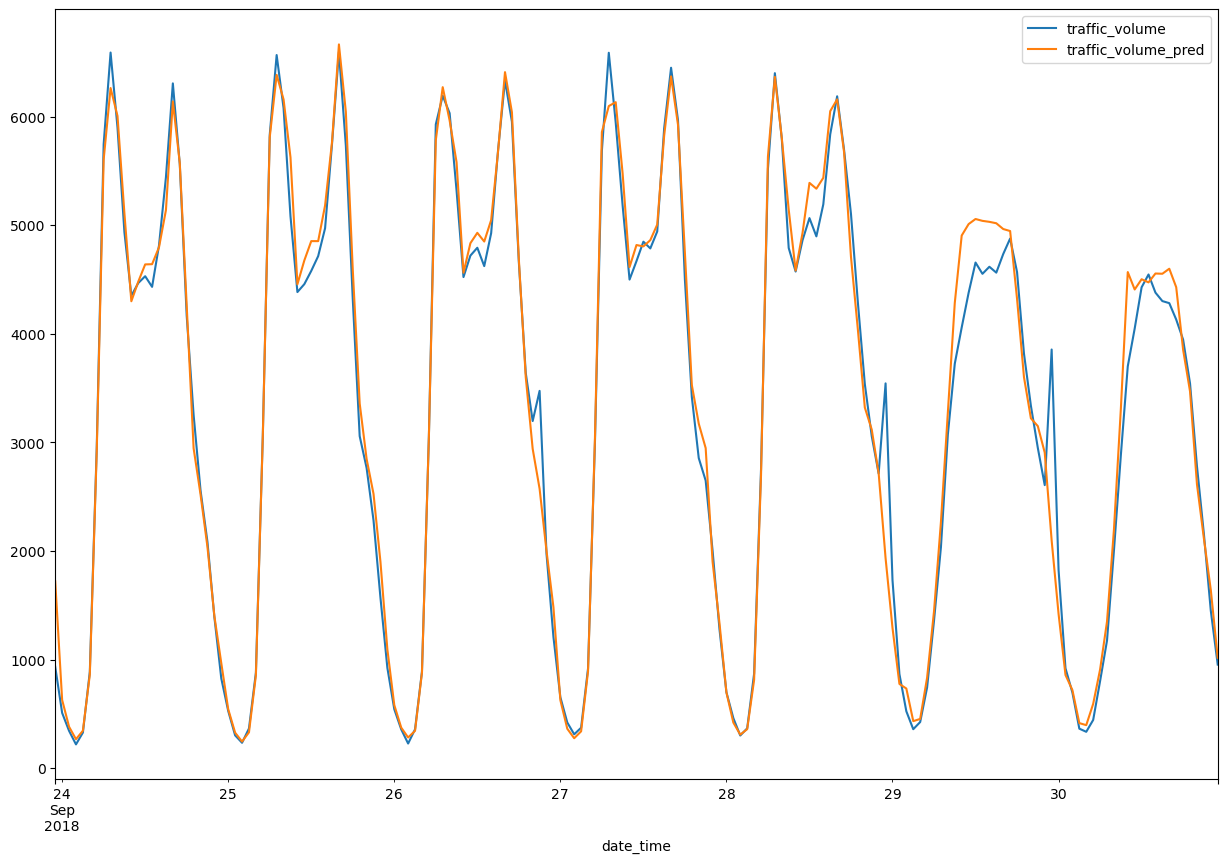

In [34]:
fig, ax = plt.subplots(1, 1)

test.plot(x='date_time', y='traffic_volume', ax = ax, figsize=(15,10))
test.plot(x='date_time', y='traffic_volume_pred', ax = ax, figsize=(15,10))

# Добавим лаги

In [52]:
data_lag = data.copy()
for i in range(7*24, 15*24, 24):  # Создадим временной лаг на N дней
    data_lag[f'Lag_{i}'] = data_lag['traffic_volume'].shift(i)
data_lag.dropna(inplace=True)
train_test_split_date = max_datetime - timedelta(days=7)
data_train = data_lag[data_lag['date_time']<train_test_split_date]
data_test = data_lag[data_lag['date_time']>=train_test_split_date]


In [57]:
data_lag.head()

,date_time,traffic_volume,holiday,temp,month,dayofweek,hour,dayofyear,Lag_168,Lag_192,Lag_216,Lag_240,Lag_264,Lag_288,Lag_312,Lag_336
35366,2016-10-14 23:00:00,1703.0,0,291.381,10,4,23,288,1766.0,1011.0,2110.0,1138.0,1000.0,958.0,2165.0,1727.0
35367,2016-10-15 00:00:00,1148.0,0,291.381,10,5,0,289,1186.0,517.0,649.0,514.0,713.0,552.0,1794.0,1195.0
35368,2016-10-15 01:00:00,682.0,0,291.381,10,5,1,289,656.0,333.0,429.0,314.0,671.0,407.0,776.0,776.0
35369,2016-10-15 02:00:00,547.0,0,291.628,10,5,2,289,539.0,264.0,274.0,243.0,557.0,264.0,666.0,666.0
35370,2016-10-15 03:00:00,391.0,0,291.628,10,5,3,289,371.0,352.0,324.0,316.0,560.0,341.0,413.0,448.0


In [58]:
X_train = data_train.drop(['date_time', 'traffic_volume'], axis=1)
y_train = data_train['traffic_volume']
X_test = data_test.drop(['date_time', 'traffic_volume'], axis=1)
y_test = data_test['traffic_volume']

In [59]:
rf = RandomForestRegressor(n_estimators = 1000, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=0)

In [60]:
forecast = rf.predict(X_test)

In [61]:
test = data_test.copy()
test['traffic_volume_pred'] = list(forecast)

In [62]:
print('mae={0}, mape={1}'.format(mae(test['traffic_volume'], test['traffic_volume_pred']),mape(test['traffic_volume'], test['traffic_volume_pred'])))

mae=167.97002898703857, mape=0.07991784617712756


<Axes: xlabel='date_time'>

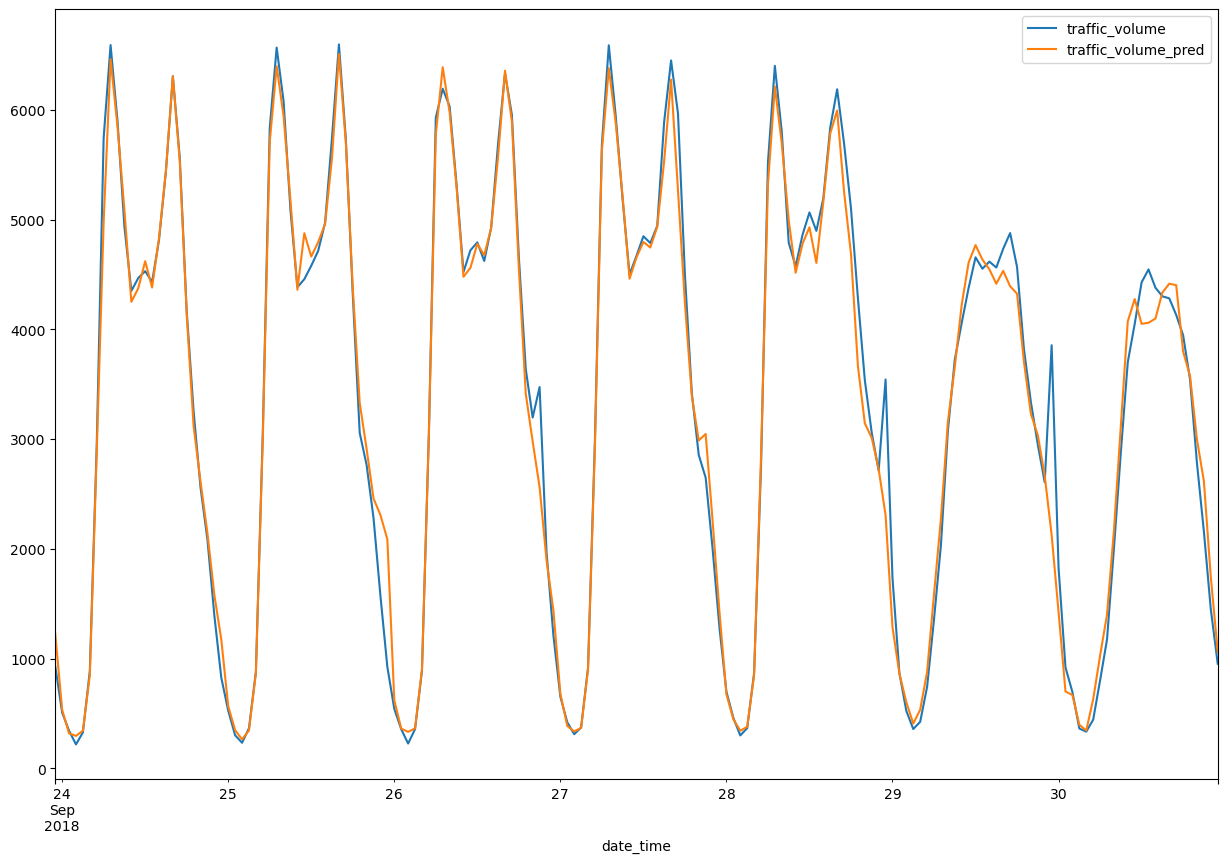

In [63]:
fig, ax = plt.subplots(1, 1)

test.plot(x='date_time', y='traffic_volume', ax = ax, figsize=(15,10))
test.plot(x='date_time', y='traffic_volume_pred', ax = ax, figsize=(15,10))

# Добавим скользящее среднее и дисперсию за день и за неделю

In [65]:
data_roll = data_lag.copy()
data_roll['r_mean_1'] = data_roll['traffic_volume'].rolling(24).mean().shift(7*24)
data_roll['r_std_1'] = data_roll['traffic_volume'].rolling(24).std().shift(7*24)
data_roll['r_mean_1'] = data_roll['traffic_volume'].rolling(7*24).mean().shift(7*24)
data_roll['r_std_1'] = data_roll['traffic_volume'].rolling(7*24).std().shift(7*24)
data_roll.tail()

,date_time,traffic_volume,holiday,temp,month,dayofweek,hour,dayofyear,Lag_168,Lag_192,Lag_216,Lag_240,Lag_264,Lag_288,Lag_312,Lag_336,r_mean_1,r_std_1
52546,2018-09-30 19:00:00,3543.0,0,283.45,9,6,19,273,3516.0,4347.0,3958.0,2957.0,3460.0,3309.0,2897.0,3400.0,3363.559524,1940.993664
52547,2018-09-30 20:00:00,2781.0,0,282.76,9,6,20,273,2846.0,3602.0,3255.0,2740.0,2865.0,2805.0,2466.0,3092.0,3362.095238,1941.292523
52548,2018-09-30 21:00:00,2159.0,0,282.73,9,6,21,273,2346.0,2985.0,2931.0,3497.0,2576.0,2400.0,2090.0,2623.0,3360.446429,1942.041511
52549,2018-09-30 22:00:00,1450.0,0,282.09,9,6,22,273,1635.0,2480.0,2570.0,2356.0,1693.0,2631.0,1434.0,1725.0,3359.910714,1942.507710
52550,2018-09-30 23:00:00,954.0,0,282.12,9,6,23,273,934.0,1871.0,2179.0,1633.0,994.0,1501.0,869.0,1088.0,3358.994048,1943.622257


In [66]:
data_roll.dropna(inplace=True)
train_test_split_date = max_datetime - timedelta(days=7)
data_train = data_roll[data_roll['date_time']<train_test_split_date]
data_test = data_roll[data_roll['date_time']>=train_test_split_date]


In [67]:
X_train = data_train.drop(['date_time', 'traffic_volume'], axis=1)
y_train = data_train['traffic_volume']
X_test = data_test.drop(['date_time', 'traffic_volume'], axis=1)
y_test = data_test['traffic_volume']

In [68]:
rf = RandomForestRegressor(n_estimators = 1000, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=0)

In [69]:
forecast = rf.predict(X_test)

In [70]:
test = data_test.copy()
test['traffic_volume_pred'] = list(forecast)

In [71]:
print('mae={0}, mape={1}'.format(mae(test['traffic_volume'], test['traffic_volume_pred']),mape(test['traffic_volume'], test['traffic_volume_pred'])))

mae=167.66248482671173, mape=0.07662736716801916


<Axes: xlabel='date_time'>

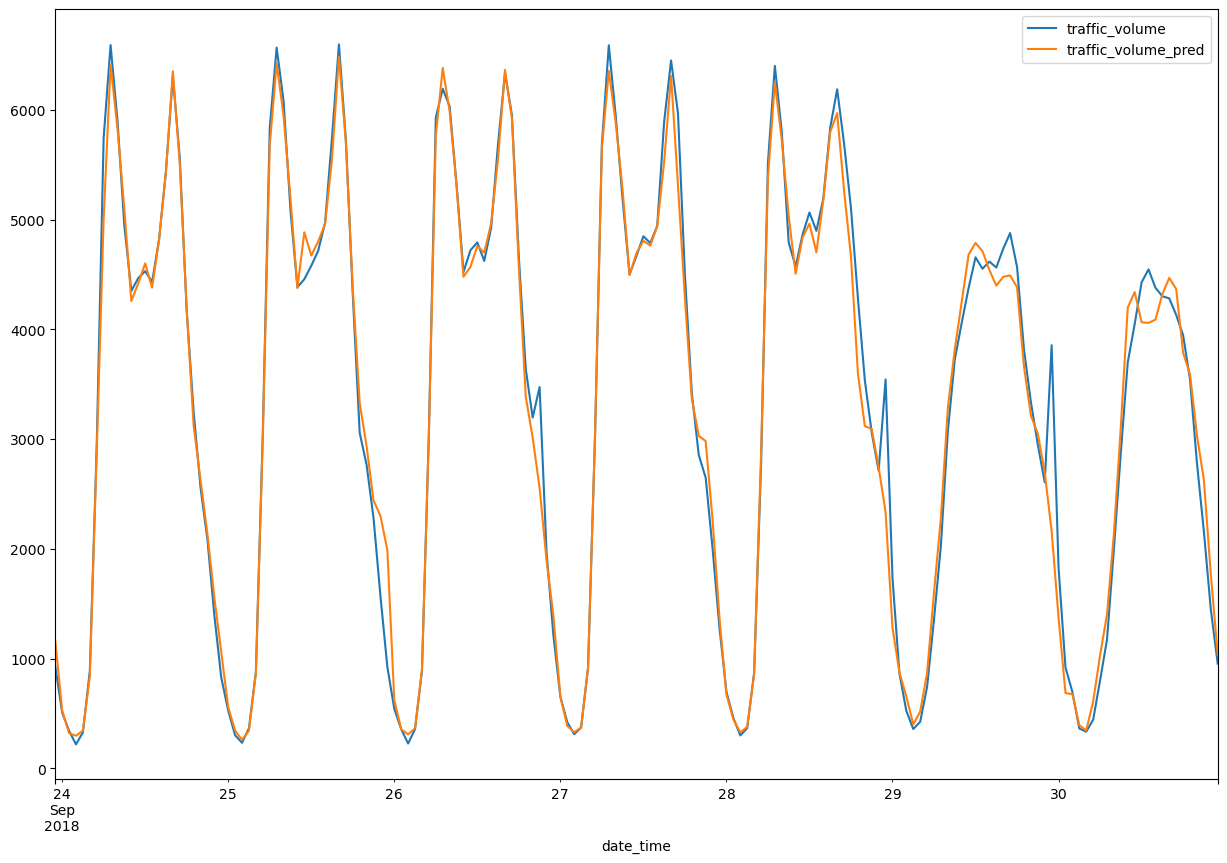

In [72]:
fig, ax = plt.subplots(1, 1)

test.plot(x='date_time', y='traffic_volume', ax = ax, figsize=(15,10))
test.plot(x='date_time', y='traffic_volume_pred', ax = ax, figsize=(15,10))